In [1]:
import pdb
import os
from pathlib import Path
import pandas as pd
import numpy as np
import random
import sys
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from plotnine import *
import matplotlib.pyplot as plt

import warnings
#warnings.filterwarnings('ignore')

In [2]:
# Import the prewritten helper functions 
from py_helper_functions import *

In [3]:
path = Path(os.getcwd())
base_dir = path.parent.parent

In [4]:
#Windows format
data_in = os.path.join(str(base_dir) , "da_data_repo\\bisnode-firms\\clean\\")
data_out = os.path.join(str(base_dir) , "da_data_repo\\bisnode-firms\\")
output = os.path.join(data_out,'output')
func = os.path.join(str(base_dir) ,   "da_case_studies\\ch00-tech-prep\\")

In [5]:
current_csv_path = os.path.join(data_out,"bisnode_firms_clean.csv")
data = pd.read_csv(current_csv_path)

In [6]:
# Define variable sets ----------------------------------------------
# (making sure we use categories)
data['urban_m'] = data['urban_m'].astype("category")
data['ind2_cat'] = data['ind2_cat'].astype("category")
data['m_region_loc'] = data['region_m'].astype("category")

rawvars = ["curr_assets", "curr_liab", "extra_exp", "extra_inc", "extra_profit_loss", "fixed_assets",
              "inc_bef_tax", "intang_assets", "inventories", "liq_assets", "material_exp", "personnel_exp",
              "profit_loss_year", "sales", "share_eq", "subscribed_cap"]
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = ["total_assets_bs", "fixed_assets_bs", "liq_assets_bs", "curr_assets_bs",
            "share_eq_bs", "subscribed_cap_bs", "intang_assets_bs", "extra_exp_pl",
            "extra_inc_pl", "extra_profit_loss_pl", "inc_bef_tax_pl", "inventories_pl",
            "material_exp_pl", "profit_loss_year_pl", "personnel_exp_pl"]
engvar2 = ["extra_profit_loss_pl_quad", "inc_bef_tax_pl_quad",
             "profit_loss_year_pl_quad", "share_eq_bs_quad"]
engvar3=[]
for col in data.columns:
    if col.endswith('flag_low') or col.endswith('flag_high') or col.endswith('flag_error') or col.endswith('flag_zero'):
        engvar3.append(col)


d1 =  ["d1_sales_mil_log_mod", "d1_sales_mil_log_mod_sq",
         "flag_low_d1_sales_mil_log", "flag_high_d1_sales_mil_log"]
hr = ["female", "ceo_age", "flag_high_ceo_age", "flag_low_ceo_age",
        "flag_miss_ceo_age", "ceo_count", "labor_avg_mod",
        "flag_miss_labor_avg", "foreign_management"]

In [7]:
#Creat dummy columns from category variables and drop first level

ind2_catmat = patsy.dmatrix("0 + C(ind2_cat)",data, return_type="dataframe")
ind2_catmat = ind2_catmat.drop(['C(ind2_cat)[26.0]'], axis=1)

m_region_locmat = patsy.dmatrix("0 + C(m_region_loc)",data, return_type="dataframe")
m_region_locmat = m_region_locmat.drop(['C(m_region_loc)[Central]'], axis=1)

urban_mmat = patsy.dmatrix("0 + C(urban_m)",data, return_type="dataframe")
urban_mmat = urban_mmat.drop(['C(urban_m)[1.0]'], axis=1)

In [8]:
basevars = data[["sales_mil_log", "sales_mil_log_sq", "d1_sales_mil_log_mod", "profit_loss_year_pl"]]

# Define X1
X1 = pd.concat([basevars, ind2_catmat], axis=1)
# Define X2
X2additional_vars = data[["fixed_assets_bs", "share_eq_bs","curr_liab_bs", "curr_liab_bs_flag_high", \
                          "curr_liab_bs_flag_error",  "age", "foreign_management"]]
X2 = pd.concat([X1, X2additional_vars], axis=1)
# Define X3
firm = pd.concat([data[["age", "age2", "new"]], ind2_catmat, m_region_locmat,urban_mmat], axis=1)
X3 = pd.concat([data[["sales_mil_log", "sales_mil_log_sq"] + engvar + d1], firm], axis=1)
# Define X4
X4 = pd.concat([data[["sales_mil_log", "sales_mil_log_sq"] + engvar + d1 \
                                 + engvar2 + engvar3 + hr + qualityvars], firm], axis=1)

In [9]:
# Define X5
#Creat matrix for interactions1 variables
int1mat = patsy.dmatrix("0 + C(ind2_cat):age + C(ind2_cat):age2 + C(ind2_cat):d1_sales_mil_log_mod \
                + C(ind2_cat):sales_mil_log + C(ind2_cat):ceo_age + C(ind2_cat):foreign_management \
                + C(ind2_cat):female + C(ind2_cat):C(urban_m) + C(ind2_cat):labor_avg_mod", data, return_type="dataframe")
#Drop first level to get k-1 dummies out of k categorical levels 
for col in int1mat.columns:
    if col.startswith('C(ind2_cat)[26.0]') or col.endswith('C(urban_m)[1.0]'):
        int1mat = int1mat.drop([col], axis=1)
        
#Creat matrix for interactions2 variables        
int2mat = patsy.dmatrix("0 + sales_mil_log:age + sales_mil_log:female + sales_mil_log:profit_loss_year_pl \
                + sales_mil_log:foreign_management", data, return_type="dataframe")
X5 = pd.concat([X4, int1mat, int2mat], axis=1)

In [10]:
# Define logitvars for LASSO
logitvars = pd.concat([X4, int1mat, int2mat], axis=1)

In [11]:
# Define rfvars for RF (no interactions, no modified features)
rfvars  = pd.concat([data[["sales_mil", "d1_sales_mil_log"] + rawvars + hr + qualityvars], firm], axis=1)

In [12]:
y = data['default']

In [13]:
# Train Logit Models ----------------------------------------------

logit_model_vars = [X1, X2, X3, X4, X5]

C_values=[1e4,1e9]
logit_models = dict()
CV_RMSE_folds = dict()
CV_AUC_folds = dict()
CV_RMSE = dict()
CV_AUC = dict()
nvars = dict()

k = KFold(n_splits=5, shuffle=True, random_state=42)

index_train, index_holdout= train_test_split(
    data.index.values, train_size=round(0.8*len(data.index)), random_state=42)

y_train = y.iloc[index_train]
y_holdout = y.iloc[index_holdout]

FP = 1
FN = 10
cost = FN/FP
# the prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))
prevelance = y_train.sum()/len(y_train)

# Randomforest

In [14]:
#################################################
# PREDICTION WITH RANDOM FOREST
#################################################

# -----------------------------------------------
# RANDOM FOREST GRAPH EXAMPLE
# -----------------------------------------------

In [15]:
data_for_graph = data[['sales_mil','profit_loss_year','foreign_management']]

In [16]:
data_for_graph_train, data_for_graph_holdout, y_train, y_holdout = train_test_split(data_for_graph, y, train_size=round(0.8*len(data_for_graph.index)), random_state=101)

In [17]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(ccp_alpha=0.0028,min_samples_leaf=100, \
                            max_depth=3).fit(data_for_graph_train, y_train)

In [18]:
### Failed to do visualization, could be because of Windows OS....
from sklearn.tree import export_graphviz
export_graphviz(clf, feature_names = data_for_graph_train.columns)
#from IPython.display import Image  
#from six import StringIO 
#from sklearn.tree import export_graphviz
#import pydot 
#import graphviz 
#features = data_for_graph_train.columns
#dot_data = StringIO()  
#exp=export_graphviz(clf, out_file=dot_data,feature_names=features,filled=True,rounded=True)
#graph = graphviz.Source(exp)  
#graph 
#graph = pydot.graph_from_dot_data(dot_data.getvalue())  
#Image(graph[0].create_png())

'digraph Tree {\nnode [shape=box] ;\n0 [label="sales_mil <= 0.031\\ngini = 0.324\\nsamples = 15229\\nvalue = [12130, 3099]"] ;\n1 [label="profit_loss_year <= -1085.185\\ngini = 0.431\\nsamples = 6371\\nvalue = [4372, 1999]"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="gini = 0.479\\nsamples = 3246\\nvalue = [1953, 1293]"] ;\n1 -> 2 ;\n3 [label="gini = 0.35\\nsamples = 3125\\nvalue = [2419, 706]"] ;\n1 -> 3 ;\n4 [label="profit_loss_year <= -531.481\\ngini = 0.218\\nsamples = 8858\\nvalue = [7758, 1100]"] ;\n0 -> 4 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;\n5 [label="gini = 0.341\\nsamples = 3091\\nvalue = [2417, 674]"] ;\n4 -> 5 ;\n6 [label="gini = 0.137\\nsamples = 5767\\nvalue = [5341, 426]"] ;\n4 -> 6 ;\n}'

<Figure size 432x288 with 0 Axes>

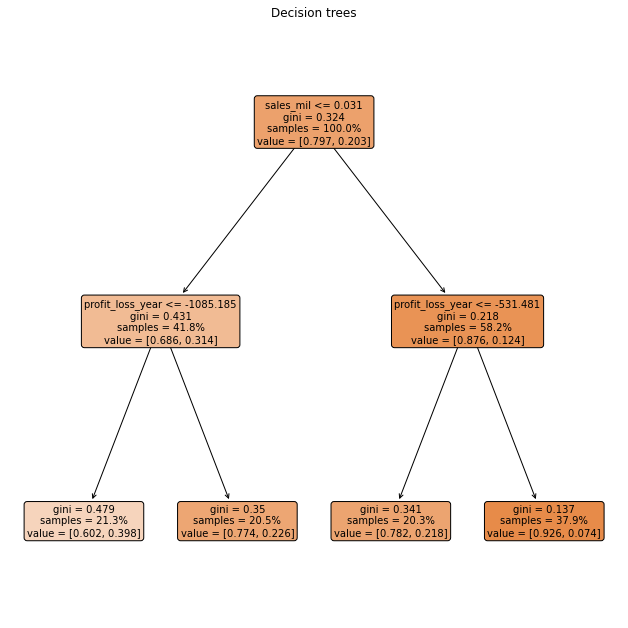

In [19]:
from sklearn.tree import plot_tree
plt.figure()
plt.figure(figsize=(11,11))
plot_tree(clf,feature_names = data_for_graph_train.columns, filled=True, rounded=True,proportion=True,fontsize = 10)
plt.title("Decision trees")
plt.show() 

In [20]:
#################################################
# Probability forest
# Split by gini, ratio of 1's in each tree, average over trees
#################################################

# 5 fold cross-validation

In [21]:
index_train, index_holdout= train_test_split(
    data.index.values, train_size=round(0.8*len(data.index)), random_state=42)

y_train = y.iloc[index_train]
y_holdout = y.iloc[index_holdout]
rfvars_train = rfvars.iloc[index_train]
rfvars_holdout = rfvars.iloc[index_holdout]

k = KFold(n_splits=5, shuffle=True, random_state=42)

In [22]:
#Failed to instal skranger, used sklearn instead 

#from skranger.ensemble import RangerForestClassifier
#grid = {'mtry': [5, 6, 7],
#        'split_rule':['gini'],
#        'min_node_size': [10, 15]}


In [23]:
from sklearn.ensemble import RandomForestClassifier

grid = {'max_features': [5, 6, 7],
        'criterion':['gini'],
        'min_samples_split': [10, 15]}

rfc = RandomForestClassifier(random_state=42,n_estimators=500, oob_score=True, n_jobs=None, verbose=0)
# This random state and defined settings produse the same best parameters as in R
# ccp_alpha? Default in R is 0.5, here 0 
# 0.5 so high that using it all the grid have the same result...
gridsearch = GridSearchCV(rfc, grid, cv=k, refit=True, n_jobs=-1)
rf_model_p = gridsearch.fit(rfvars_train, y_train)
rf_model_p.cv_results_

{'mean_fit_time': array([27.54889946, 28.95893812, 39.06289573, 49.96620045, 50.94425397,
        34.95557823]),
 'std_fit_time': array([1.0399686 , 0.80976715, 5.06812669, 2.60321753, 4.26829647,
        6.49403901]),
 'mean_score_time': array([0.736377  , 0.77800322, 1.19046946, 1.0118556 , 0.96924386,
        0.64312401]),
 'std_score_time': array([0.02353605, 0.02120542, 0.40668933, 0.1963599 , 0.18751288,
        0.18058035]),
 'param_criterion': masked_array(data=['gini', 'gini', 'gini', 'gini', 'gini', 'gini'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=[5, 5, 6, 6, 7, 7],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[10, 15, 10, 15, 10, 15],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object)

In [24]:
print(rf_model_p.best_params_)
best_mtry = rf_model_p.best_params_['max_features']
best_min_node_size = rf_model_p.best_params_['min_samples_split']

{'criterion': 'gini', 'max_features': 7, 'min_samples_split': 10}


In [25]:
rf_model_p = rf_model_p.best_estimator_.fit(rfvars_train, y_train)

In [26]:
# Get average (ie over the folds) RMSE and AUC ------------------------------------
from sklearn.model_selection import cross_val_score

RMSE = []  
brier_scores = cross_val_score(rf_model_p, rfvars_train, y_train, scoring='neg_brier_score', cv=k)

for i in brier_scores:
    RMSE.append(np.sqrt(-i))    
CV_RMSE_folds['rf_p'] = RMSE


In [27]:
CV_AUC_folds['rf_p'] = cross_val_score(rf_model_p, rfvars_train, y_train, scoring='roc_auc', cv=k)

In [28]:
CV_RMSE['rf_p'] = np.mean(CV_RMSE_folds['rf_p'])
CV_AUC['rf_p'] = np.mean(CV_AUC_folds['rf_p'])

In [29]:
# Now use loss function and search for best thresholds and expected loss over folds -----
best_tresholds_cv = []
expected_loss_cv = []

In [30]:
cv_fold = pd.DataFrame()
cv_fold['obs'] = y_train
cv_fold['pred'] = rf_model_p.predict(rfvars_train)
cv_fold['prob'] = rf_model_p.predict_proba(rfvars_train)[:,1]
fold = 1
Folds = dict()
for train_index, test_index in k.split(rfvars_train):
    Folds[fold] = cv_fold.iloc[test_index]
    fold+=1

In [31]:
for i in Folds:
    false_pos_rate, true_pos_rate, proba = roc_curve(Folds[i]['obs'], Folds[i]['prob'])
    optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)),\
                                       proba)), key=lambda x: x[0], reverse=True)[0][1]
    best_tresholds_cv.append(optimal_proba_cutoff)
    treshold_prediction = np.where(Folds[i]['prob'] < optimal_proba_cutoff, 0, 1)
    tn, fp, fn, tp = confusion_matrix(Folds[i]['obs'], treshold_prediction, labels=[0,1]).ravel()
    curr_exp_loss = (fp*FP + fn*FN)/len(Folds[i]['obs'])
    expected_loss_cv.append(curr_exp_loss)
    
# suspiciously high optimal tresholds, low expected loss numbers    
# RMSE, AUC numbers seems good

In [32]:
best_tresholds=dict()
expected_loss=dict()
best_tresholds['rf_p'] = np.mean(best_tresholds_cv)
expected_loss['rf_p'] = np.mean(expected_loss_cv)

In [33]:
rf_summary = dict(
    {'CV RMSE': CV_RMSE['rf_p'],
     'CV AUC': CV_AUC['rf_p'],
     'Avg of optimal thresholds': best_tresholds['rf_p'],
     'Threshold for Fold5': best_tresholds_cv[4],
     'Avg expected loss': expected_loss['rf_p'],
     'Expected loss for Fold5': expected_loss_cv[4]})

rf_summary

#create rf_summary.tex

{'CV RMSE': 0.3539381156646485,
 'CV AUC': 0.8090787263387504,
 'Avg of optimal thresholds': 0.33046428135444234,
 'Threshold for Fold5': 0.32959147259390237,
 'Avg expected loss': 0.01786065226461903,
 'Expected loss for Fold5': 0.017733990147783252}

In [34]:
# Create plots based on Fold5 in CV ----------------------------------------------
# ToDo like for partII

In [35]:
# Take model to holdout and estimate RMSE, AUC and expected loss ------------------------------------

In [36]:
rf_predicted_probabilities_holdout = rf_model_p.predict_proba(rfvars_holdout)[:,1]
np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))

0.35712202165667933

In [37]:
# ROC AUC  on holdout
roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)

0.8059875893145593

In [38]:
# Get expected loss on holdout
holdout_treshold = np.where(rf_predicted_probabilities_holdout < best_tresholds['rf_p'], 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1]).ravel()
expected_loss_holdout = (fp*FP + fn*FN)/len(y_holdout)
expected_loss_holdout

# To have lower expected loss as in R best_tresholds['rf_p'] should be around 0.1

1.0249540320462307

In [39]:
#################################################
# Classification forest
# Split by Gini, majority vote in each tree, majority vote over trees
#################################################
# Show expected loss with classification RF and default majority voting to compare


#???? how to do it, which function

In [40]:
# Summary results ---------------------------------------------------

nvars = dict()
nvars["rf_p"] = len(rfvars.columns)
#in R length(rfvars) counts 1 for category variables (39), here they count category number-1 (44)


In [41]:
summary_results = np.transpose(pd.DataFrame.from_dict([nvars, CV_RMSE, CV_AUC, best_tresholds,expected_loss], orient='columns'))
summary_results.columns = ["Number of predictors", "CV RMSE", "CV AUC", "CV threshold", "CV expected Loss"]
summary_results

,Number of predictors,CV RMSE,CV AUC,CV threshold,CV expected Loss
rf_p,44.0,0.353938,0.809079,0.330464,0.017861
